# Claude vision

In this notebook we will use the vision language model [claude](https://claude.ai) to describe images.

In [1]:
import anthropic
from skimage.io import imread
import stackview
from image_utilities import numpy_to_bytestream, extract_json
import base64
import json

## Example image
First we load a medical tomography image.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 5, ..., 6, 3, 3],
                  ...,
                  [0, 0, 0, ..., 3, 2, 3],
                  [0, 0, 0, ..., 1, 4, 9],
                  [0, 0, 0, ..., 1, 4, 8]], dtype=uint8)
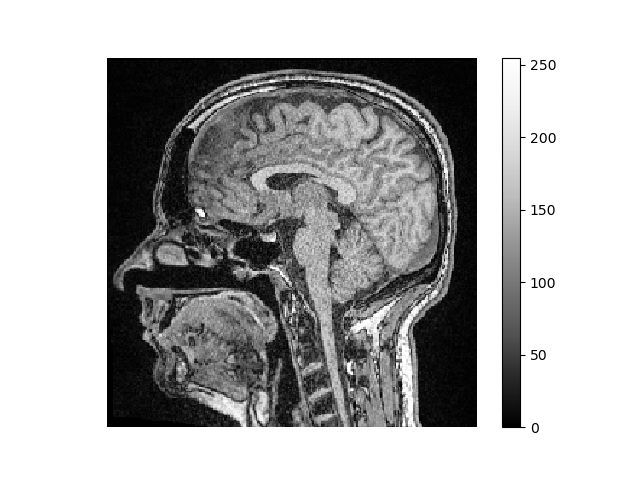
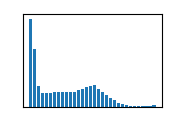

In [2]:
mri = imread("data/Haase_MRT_tfl3d1.tif")[100]
stackview.insight(mri)

We will now send the image to claude and ask it the same questions.

In [3]:
def prompt_anthropic(prompt:str, image=None, model:str = "claude-3-7-sonnet-20250219"):
    from anthropic import Anthropic

    client = Anthropic()
    
    if image is None:
        user_message = {
                    "role": "user",
                    "content": prompt,
                }
    else:
        user_message = image_to_message_claude(image, prompt)

    response = client.messages.create(
        messages=[user_message],
        model=model,
        max_tokens=8092,
    )
    reply = response.content[0].text

    return reply


def image_to_message_claude(image, prompt):
    import base64
    from image_utilities import numpy_to_bytestream

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return {
            "role": 'user',
            "content": [
                {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_image}},
                {"type": "text", "text": prompt}
            ]
        }

In [4]:
prompt_anthropic("what's in this image?", mri)

'This image appears to be a sagittal (side view) MRI scan of a human head. The scan shows the brain, skull, nasal cavity, and parts of the upper neck in black and white contrast. In this type of medical imaging, different tissues appear in varying shades of gray, with the brain tissue visible in the upper portion of the skull cavity, showing characteristic folding patterns. This type of medical imaging is commonly used by doctors to examine brain structure, diagnose conditions, and plan treatments without invasive procedures.'

## Bounding box segmentation
Models such as claude have some capabilities in bounding-box segmentation of objects.

In [5]:
cat_image = imread("data/real_cat.png")

Based on the image, here's the bounding box for the cat in JSON format:

```json
{"x": 115, "y": 75, "width": 185, "height": 235}
```

This is an approximate bounding box that encompasses the black and white cat sitting next to what appears to be a white microscope or similar scientific instrument on a wooden surface. The cat has distinctive black patches on a primarily white coat and is looking off to the side.


StackViewNDArray([[[176, 178, 179],
                   [175, 178, 178],
                   [177, 177, 180],
                   ...,
                   [182, 186, 188],
                   [185, 188, 191],
                   [191, 194, 197]],

                  [[178, 180, 181],
                   [178, 179, 181],
                   [178, 180, 181],
                   ...,
                   [185, 189, 192],
                   [187, 191, 192],
                   [191, 195, 198]],

                  [[181, 183, 185],
                   [180, 182, 183],
                   [180, 181, 183],
                   ...,
                   [190, 193, 196],
                   [189, 193, 196],
                   [192, 195, 198]],

                  ...,

                  [[125,  91,  66],
                   [124,  90,  65],
                   [123,  89,  65],
                   ...,
                   [137,  92,  64],
                   [136,  91,  62],
                   [135,  89,  61]],

                  [[122,  88,  64],
                   [121,  87,  63],
                   [121,  87,  63],
                   ...,
                   [142,  96,  68],
                   [142,  96,  68],
                   [139,  94,  65]],

                  [[120,  86,  62],
                   [120,  86,  60],
                   [119,  85,  61],
                   ...,
                   [144,  99,  70],
                   [144,  99,  70],
                   [142,  97,  68]]], dtype=uint8)
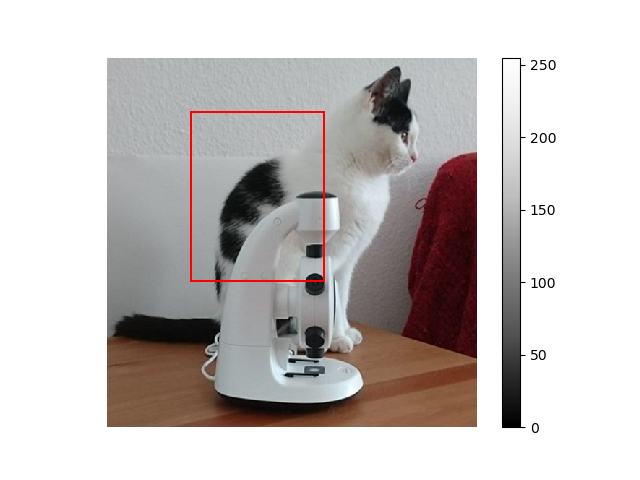
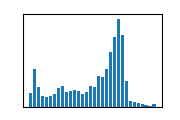

In [6]:
reply = prompt_anthropic("""
Give me a json object of a bounding boxes around the cat in this image. 
The format should be like this: {'x':int,'y':int,'width':int,'height':int}
""", cat_image)
print(reply)
bb = json.loads(extract_json(reply))
bb

stackview.add_bounding_boxes(cat_image, [bb])

Bounding box segmentation using vision language models are an active research field. To see how well this works, we can inspect a couple of images.

In [7]:
visualizations = []

for filename in ["data/pinata.jpg", "data/real_cat.png", "data/sheeps.jpg", "data/guinea_pig.jpg"]:
    image = imread(filename)
    
    reply = prompt_anthropic("""Give me a json object of a list of bounding boxes around each animal in this 512x512 pixel large image. 
The format should be like this:

```json
[
    {
        'x':int,
        'y':int, 
        'width':int, 
        'height':int,
        'description':str,
        'font_size':25
    }
]
```
""", image)

    bb = json.loads(extract_json(reply))

    vis = stackview.add_bounding_boxes(image, bb)
    visualizations.append(vis)


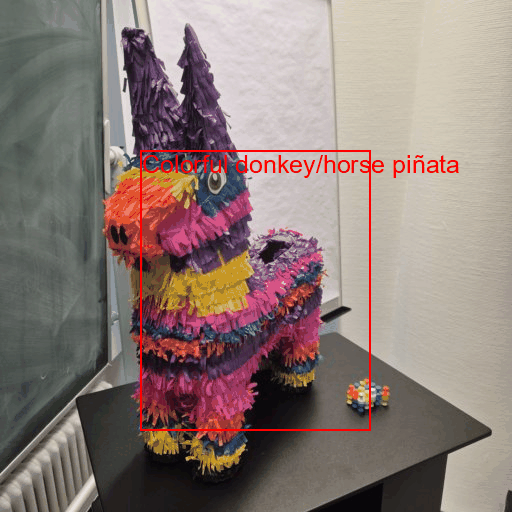

In [8]:
stackview.animate(visualizations, frame_delay_ms=2000)

## Exercise
Load blobs.tif and ask claude how many objects are in the image.